In [1]:
import os
import numpy as np
from PIL import Image
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
zip_file_path = 'archive.zip'
extract_dir = 'extracted_data'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
train_folder = os.path.join(extract_dir, 'train')
test_folder = os.path.join(extract_dir, 'test')

In [4]:
# Function to load and inspect images and labels from subdirectories
def inspect_images_from_subdirs(folder, num_images=5):
    images, labels = [], []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for i, filename in enumerate(os.listdir(subdir_path)):
                if i >= num_images:
                    break
                if filename.endswith(('.jpg', '.png')):
                    img = Image.open(os.path.join(subdir_path, filename))
                    img = img.resize((128, 128))
                    img = img.convert('L')  # Ensure grayscale
                    images.append(np.array(img))
                    labels.append(subdir)  # Use the subdirectory name as the label
    return images, labels

In [5]:
# Inspect a few images and labels from the train and test folders
train_images_sample, train_labels_sample = inspect_images_from_subdirs(train_folder)
test_images_sample, test_labels_sample = inspect_images_from_subdirs(test_folder)

In [6]:
print('Sample train images shape:', np.array(train_images_sample).shape)
print('Sample train labels:', train_labels_sample)
print('Sample test images shape:', np.array(test_images_sample).shape)
print('Sample test labels:', test_labels_sample)

Sample train images shape: (35, 128, 128)
Sample train labels: ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'happy', 'happy', 'happy', 'happy', 'angry', 'angry', 'angry', 'angry', 'angry', 'sad', 'sad', 'sad', 'sad', 'sad', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'surprise', 'surprise', 'surprise', 'surprise', 'surprise', 'fear', 'fear', 'fear', 'fear', 'fear']
Sample test images shape: (35, 128, 128)
Sample test labels: ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'happy', 'happy', 'happy', 'happy', 'angry', 'angry', 'angry', 'angry', 'angry', 'sad', 'sad', 'sad', 'sad', 'sad', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'surprise', 'surprise', 'surprise', 'surprise', 'surprise', 'fear', 'fear', 'fear', 'fear', 'fear']


In [7]:
# Preprocess the data
def preprocess_images(images):
    images = np.array(images)
    images = images.astype('float32') / 255.0  # Normalize to [0, 1]
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    return images

train_images = preprocess_images(train_images_sample)
test_images = preprocess_images(test_images_sample)

print('Preprocessed train images shape:', train_images.shape)
print('Preprocessed test images shape:', test_images.shape)

Preprocessed train images shape: (35, 128, 128, 1)
Preprocessed test images shape: (35, 128, 128, 1)


In [8]:
# Define the encoder model
input_shape = (128, 128, 1)
latent_dim = 64

encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation='relu')(x)

encoder = models.Model(encoder_inputs, x, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7385

In [9]:
# Define the decoder model
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             2129920   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       147584    
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        7379

In [10]:
# Define the VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

In [11]:
# Instantiate and compile the VAE model with a lower learning rate
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [12]:
# Define image size and batch size
image_size = (64, 64)
batch_size = 32

In [13]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Load the train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    color_mode='grayscale',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

In [ ]:
# Build and compile the model
input_shape = (128, 128, 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    color_mode='grayscale'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Train the model
autoencoder.fit(
    train_generator,
    epochs=10,  # Increase the number of epochs
    validation_data=validation_generator
)

Epoch 1/10
718/718 [==============================] - 81s 113ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 2/10
718/718 [==============================] - 64s 89ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/10
718/718 [==============================] - 65s 91ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 4/10
718/718 [==============================] - 66s 92ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/10
718/718 [==============================] - 65s 90ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/10
718/718 [==============================] - 65s 91ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/10
718/718 [==============================] - 65s 91ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
718/718 [==============================] - 65s 90ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/10
718/718 [==============================] - 64s 89ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
718/718 [==============================] - 66s 92ms/step - loss: 0.00

1/1 [==============================] - 1s 721ms/step


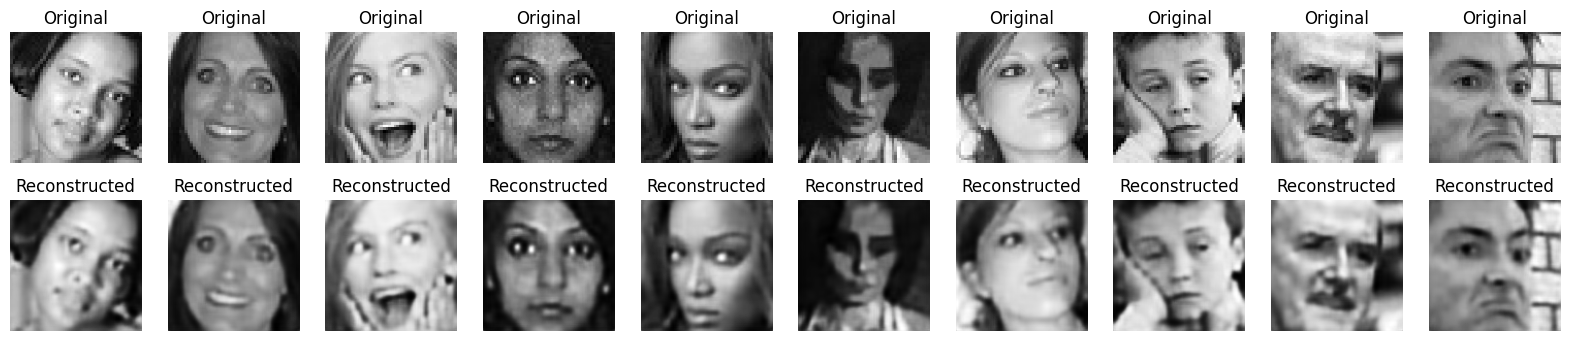

In [ ]:
import matplotlib.pyplot as plt

# Function to display original and reconstructed images
def display_reconstructed_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(128, 128), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(128, 128), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Generate some reconstructed images
num_images_to_display = 10
sample_test_images, _ = next(test_generator)
reconstructed_images = autoencoder.predict(sample_test_images[:num_images_to_display])

# Display the original and reconstructed images
display_reconstructed_images(sample_test_images, reconstructed_images)


In [ ]:
# Save the model
model_save_path = 'autoencoder_model.h5'
autoencoder.save(model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at autoencoder_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
%%shell
jupyter nbconvert --to html Final_VAE.ipynb

SyntaxError: invalid syntax (<ipython-input-16-ef758f44e303>, line 1)